<h1> import libraries

In [ ]:
import matplotlib.pyplot as plt 
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet  import DenseNet169
from tensorflow.keras import Model
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Flatten ,Dropout , Dense  ,Conv2D , MaxPooling2D ,BatchNormalization 
import numpy as np 
import pandas as pd 

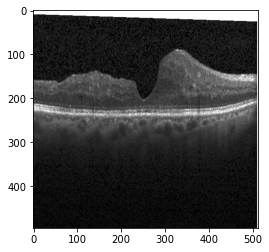

In [2]:
image = plt.imread("../input/kermany2018/OCT2017 /train/DME/DME-1072015-1.jpeg")
plt.imshow(image,cmap='gray')


<h1> Explore data 

In [3]:
TrainPath="../input/kermany2018/OCT2017 /train/"
TestPath="../input/kermany2018/OCT2017 /test/"
ValidationPath="../input/kermany2018/OCT2017 /val/"

print(TrainPath)
print(TestPath)
print(ValidationPath)

../input/kermany2018/OCT2017 /train/
../input/kermany2018/OCT2017 /test/
../input/kermany2018/OCT2017 /val/


the numbers of images in DRUSEN class :  8616
(496, 512)


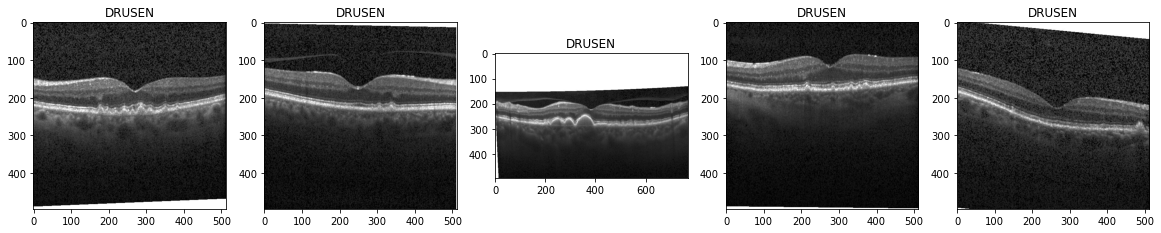

the numbers of images in DME class :  11348
(496, 512)


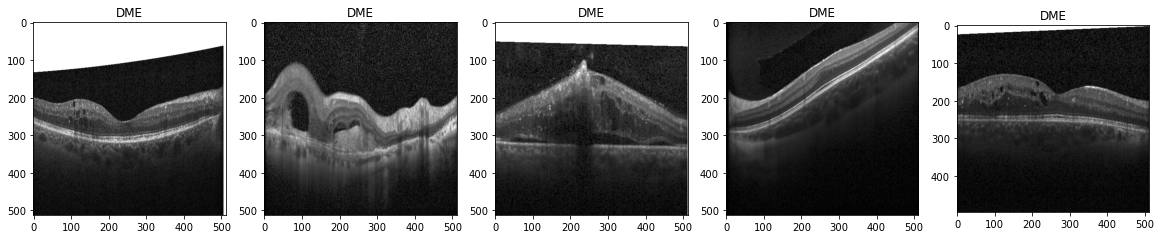

the numbers of images in CNV class :  37205
(496, 512)


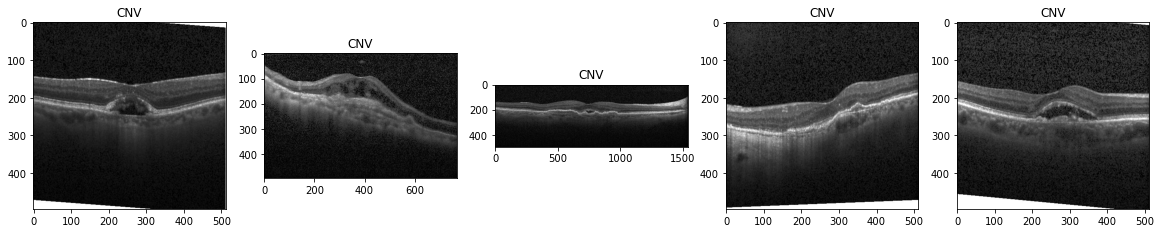

the numbers of images in NORMAL class :  26315
(496, 512)


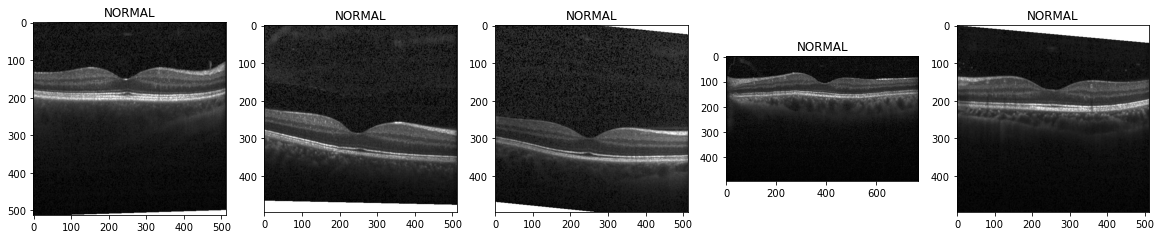

In [3]:
trainClass=os.listdir(TrainPath)
for i in range(len(trainClass)):
    imageInfile=[]
    imageInfile=os.listdir(os.path.join(TrainPath,trainClass[i]))
    print( f"the numbers of images in {trainClass[i]} class : " , len(imageInfile))
    plt.figure(figsize=(20,20))
    for j in range(5):
        
        plt.subplot(1,5,j+1)
        image=plt.imread(os.path.join(os.path.join(TrainPath,trainClass[i]),imageInfile[j]))
        plt.title(trainClass[i])
        plt.imshow(image,cmap='gray')
    print(image.shape)
    plt.show()

<h2>after explore dataset we show these images arenot in the same size and same scale </h2>
    the dataset isnot balance , Unfortunately the dataset imbalance 
    I use the Data Augmentation to read , resize , rescale and balance dataset(but we not do this now) 

<h1>DataAugmentation

In [4]:
imageDelegate=ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    )


In [5]:
ImageSize=224
trainGenerator=imageDelegate.flow_from_directory(
    TrainPath,
    batch_size=50,
    target_size=(ImageSize,ImageSize)  
)

testGenerator =imageDelegate.flow_from_directory(
     TestPath,
     batch_size= 10,
     target_size=(ImageSize, ImageSize)
)

validationGenerator =imageDelegate.flow_from_directory(
     ValidationPath,
     batch_size=4,
     target_size=(ImageSize, ImageSize)
)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [6]:
Labels={0:"BME",1:"CNV",2:"DRUSEN",3:"NORMAL"}
def GetLabel(key):
    return Labels[key]


print(GetLabel(0))
print(GetLabel(1))
print(GetLabel(2))
print(GetLabel(3))

BME
CNV
DRUSEN
NORMAL


In [ ]:
plt.figure(figsize=(20,20))
for i  in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(trainGenerator.__getitem__(0)[0][i])
    plt.title(GetLabel(np.argmax(trainGenerator.__getitem__(0)[1][i])))
    
    


In [ ]:
trainGenerator.__getitem__(0)[0][1].shape

<h1>Build Models

<h1>Densesnet169 Model 

In [7]:
preTrainedModelDenseNet169 = DenseNet169(input_shape =( ImageSize, ImageSize, 3), include_top = False, 
weights = None)
preTrainedModelDenseNet169.load_weights("../input/densenet-keras/DenseNet-BC-169-32-no-top.h5")
for layer in preTrainedModelDenseNet169.layers:
    layer.trainable = False  
preTrainedModelDenseNet169.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [8]:

#DenseNet169 Model
x=Flatten()(preTrainedModelDenseNet169.output)

#Fully Connection Layers
# FC1
x=Dense(1024, activation="relu")(x)
x=Dense(512, activation="relu")(x)
#Dropout to avoid overfitting effect
x=Dropout(0.2)(x)
# FC2
x=Dense(256, activation="relu")(x)
x=Dense(128, activation="relu")(x)


#output layer
x=Dense(4,activation="sigmoid")(x)


modelDenesNet=Model(preTrainedModelDenseNet169.input,x)
modelDenesNet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

Total params: 96,826,308
Trainable params: 84,183,428
Non-trainable params: 12,642,880
__________________________________________________________________________________________________


In [13]:
#Optimzation
modelDenesNet.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])

# 30 epochs 10 + 20

#Fit model
history=modelDenesNet.fit_generator(trainGenerator,epochs=20,steps_per_epoch=83484/50,validation_data=validationGenerator ,validation_steps=96,verbose=1 )

Epoch 1/20
1670/1669 [==============================] - 408s 244ms/step - loss: 0.0448 - accuracy: 0.9681 - val_loss: 0.1585 - val_accuracy: 0.9688
Epoch 2/20
1670/1669 [==============================] - 397s 238ms/step - loss: 0.0400 - accuracy: 0.9711
Epoch 3/20
1670/1669 [==============================] - 402s 241ms/step - loss: 0.0388 - accuracy: 0.9724
Epoch 4/20
1670/1669 [==============================] - 410s 245ms/step - loss: 0.0346 - accuracy: 0.9757
Epoch 5/20
1670/1669 [==============================] - 409s 245ms/step - loss: 0.0315 - accuracy: 0.9776
Epoch 6/20
1670/1669 [==============================] - 409s 245ms/step - loss: 0.0299 - accuracy: 0.9788
Epoch 7/20
1670/1669 [==============================] - 411s 246ms/step - loss: 0.0287 - accuracy: 0.9800
Epoch 8/20
1670/1669 [==============================] - 410s 245ms/step - loss: 0.0257 - accuracy: 0.9824
Epoch 9/20
1670/1669 [==============================] - 412s 246ms/step - loss: 0.0264 - accuracy: 0.9813
Epoc

In [15]:
modelDenesNet.save("modelDenesNet2.h5")

In [16]:
modelDenesNet.evaluate(validationGenerator)

8/8 [==============================] - 0s 25ms/step - loss: 0.2959 - accuracy: 0.9688


[0.29590803384780884, 0.96875]

In [17]:
modelDenesNet.evaluate(testGenerator)

97/97 [==============================] - 6s 65ms/step - loss: 0.0213 - accuracy: 0.9938


[0.02127268724143505, 0.9938016533851624]